# Customer Segmentation with Scikit-learn and SageMaker K-Means

**Objective:** To build, deploy, and document a customer segmentation model using the K-Means clustering algorithm.

**Approach:**
1.  Use Scikit-learn's KMeans implementation for rapid prototyping and to determine the optimal number of clusters (`k`) via the elbow method.
2.  Use SageMaker's highly scalable, built-in K-Means algorithm for the final model training, preparing it for a production environment.

## Phase 1: Environment Setup & Data Explorations

### Step 1: Environment Setup & Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
import io
import os

S3_MODEL_BUCKET = os.environ.get('S3_MODEL_BUCKET', 'ml-pipeline-models-790768631355-us-east-1')
S3_DATA_BUCKET = os.environ.get('S3_DATA_BUCKET', 'ml-pipeline-data-790768631355-us-east-1')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

Dataset loaded successfully from /home/ec2-user/SageMaker/ml-pipeline/data/customer_segmentation_data.csv

Data Shape: (1000, 5)

First 5 Rows:
    Customer_ID  Age  Income  Purchases  Gender
0            1   26   50640         35    Male
1            2   18   61969         22    Male
2            3   43   89262          2  Female
3            4   60  105248         21    Male
4            5   23   53550         49    Male

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Customer_ID  1000 non-null   int64 
 1   Age          1000 non-null   int64 
 2   Income       1000 non-null   int64 
 3   Purchases    1000 non-null   int64 
 4   Gender       1000 non-null   object
dtypes: int64(4), object(1)
memory usage: 39.2+ KB

Descriptive Statistics:
        Customer_ID          Age        Income    Purchases
count  1000.000000  1000.000000  

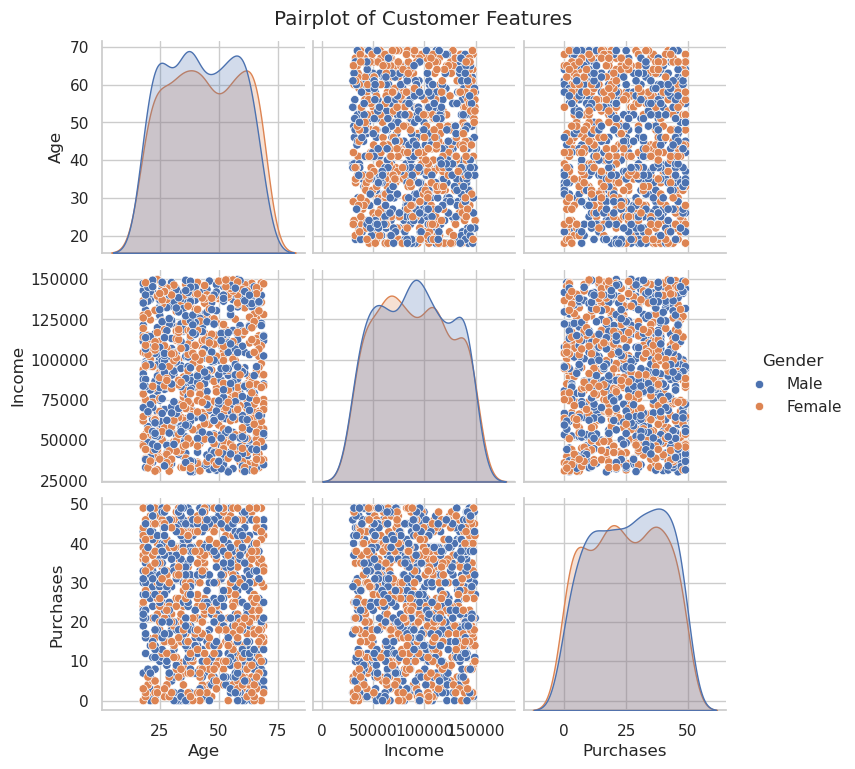

In [2]:
try:
    file_path = '/home/ec2-user/SageMaker/ml-pipeline/data/customer_segmentation_data.csv'
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from {file_path}")
except FileNotFoundError:
    print(f"Error: '{file_path}' not found.")
    df = pd.DataFrame({
        'Customer_ID': range(100), 'Age': np.random.randint(18, 70, 100),
        'Income': np.random.randint(30000, 150000, 100),
        'Purchases': np.random.randint(0, 50, 100),
        'Gender': np.random.choice(['Male', 'Female'], 100)
    })
    print("A dummy dataframe has been created to proceed.")

# Display basic information about the dataset
print("\nData Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Info:")
df.info()
print("\nDescriptive Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())

# Visualize relationships using a pairplot
sns.pairplot(df.drop('Customer_ID', axis=1), hue='Gender')
plt.suptitle('Pairplot of Customer Features', y=1.02)
plt.show() 

## EDA Findings & Observations
The initial Exploratory Data Analysis (EDA) provided several key insights that guided our pre-processing and modeling strategy.

### 1. Data Quality and Distributions:

- The dataset is of high quality, with no missing values across any of the columns.

- The distributions for Age, Income, and Purchases are all relatively uniform, without significant skew. This indicates a diverse customer base with no single dominant group in any of these categories.

### 2. Feature Relationships (from Pairplot):

- The scatter plots reveal no strong linear correlations between the primary features. For instance, there isn't a clear trend where Income increases with Age or Purchases increase with Income.

- This lack of obvious linear relationships is a crucial finding. It suggests that simple linear models would be ineffective and reinforces the choice of an unsupervised clustering algorithm like K-Means, which can uncover more complex, non-linear patterns in the data.

### 3. Impact of Gender:

- The pairplot, when colored by Gender, shows that the distributions for Male and Female customers are highly overlapping for all features.

- There are no distinct clusters or separations based on gender alone. This justifies our decision to exclude Gender from this initial clustering model, as it is unlikely to be a strong differentiating feature for segmentation.

## Summary:
The EDA confirms that the data is clean and suitable for clustering. The lack of linear correlation and the need to group customers based on multiple features make K-Means an appropriate choice. The next critical step, which we have already completed, is to scale these features to ensure the distance-based K-Means algorithm functions correctly.

## Phase 2: Data Pre-processing & Feature Engineering

### Step 3: Data Cleaning & Feature Selection

In [3]:
features = df[['Age', 'Income', 'Purchases']]
print("\nSelected features for clustering:\n", features.head())


Selected features for clustering:
    Age  Income  Purchases
0   26   50640         35
1   18   61969         22
2   43   89262          2
3   60  105248         21
4   23   53550         49


### Step 4: Feature Scaling (Critical for K-Means)

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
print("\nScaled features (first 5 rows):\n", df_scaled.head())


Scaled features (first 5 rows):
         Age    Income  Purchases
0 -1.139916 -1.134114   0.678667
1 -1.667044 -0.806455  -0.218128
2 -0.019767 -0.017083  -1.597813
3  1.100381  0.445267  -0.287112
4 -1.337589 -1.049951   1.644447


## Phase 3: Finding Optimal 'k' with Scikit-learn

### Step 5: Identifying the Optimal Number of Clusters (The Elbow Method)

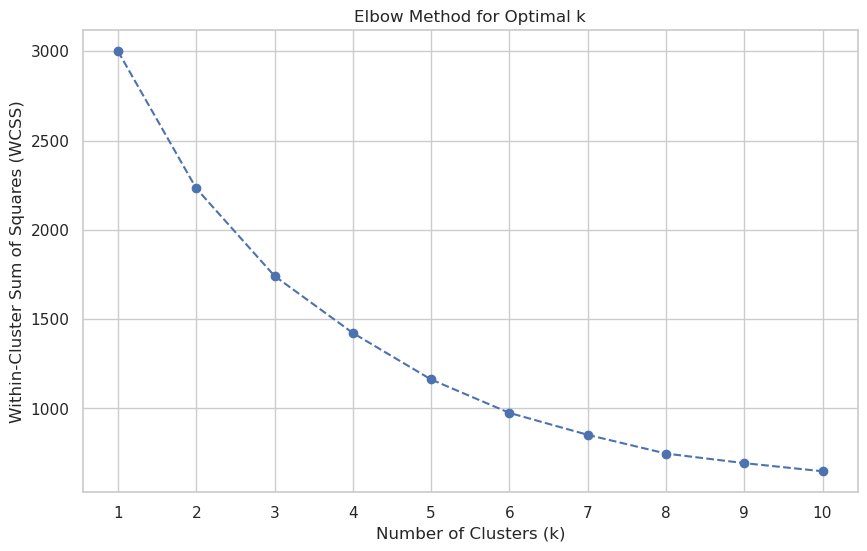

In [5]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans_sklearn = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_sklearn.fit(df_scaled)
    wcss.append(kmeans_sklearn.inertia_)

# Plot the Elbow Chart
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Observation: Elbow Method Analysis
The elbow chart displays the Within-Cluster Sum of Squares (WCSS) for k values ranging from 1 to 10. We can observe the following:

- There is a sharp decrease in WCSS from k=1 to k=4, indicating that adding more clusters up to this point significantly reduces the distance of points from their respective centroids.

- The rate of decrease slows down considerably after k=4, forming a distinct "elbow" in the graph. The curve begins to flatten out, suggesting that adding more clusters beyond this point provides diminishing returns in terms of variance explained.

- While k=4 is a strong candidate, choosing k=5 also shows a reasonable trade-off, offering slightly more granularity in segmentation.

**Decision**: Based on this analysis, we will proceed with **k=5** as the optimal number of clusters for our final model. This choice balances model complexity with its ability to capture distinct customer segments.

## Phase 4: Training Final Model with SageMaker's Built-in K-Means

### Step 6: Prepare Data for SageMaker Training

Now, we switch to using SageMaker's infrastructure for scalable training.
This requires formatting our data into the protobuf recordIO format and uploading it to S3.

## Phase 4: Training Final Model with SageMaker's Built-in K-Means

### Step 6: Prepare Data for SageMaker Training

Now, we switch to using SageMaker's infrastructure for scalable training.
This requires formatting our data into the protobuf recordIO format and uploading it to S3.


In [10]:
# SageMaker session setup
sagemaker_session = sagemaker.Session()
role = get_execution_role()
try:
    bucket = S3_MODEL_BUCKET
    print(f"Using specific S3 bucket defined by constant: {bucket}")
except NameError:
    bucket = sagemaker_session.default_bucket()
    print(f"S3_MODEL_BUCKET not defined. Using default SageMaker bucket: {bucket}")
    
prefix = 'sagemaker/customer-segmentation-kmeans'
print(f"Using S3 bucket: {bucket}")

Using specific S3 bucket defined by constant: ml-pipeline-models-790768631355-us-east-2
Using S3 bucket: ml-pipeline-models-790768631355-us-east-2


In [9]:
# Convert the data to a NumPy array of float32
train_data_np = df_scaled.to_numpy().astype('float32')

buf = io.BytesIO()
sagemaker.amazon.common.write_numpy_to_dense_tensor(buf, train_data_np)
buf.seek(0)

key = 'kmeans_training_data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = f's3://{bucket}/{prefix}/train/{key}'
print(f'Training data uploaded to: {s3_train_data}')

Training data uploaded to: s3://sagemaker-us-east-1-790768631355/sagemaker/customer-segmentation-kmeans/train/kmeans_training_data


### Step 7: Train the Model using SageMaker K-Means Estimator

In [10]:
# Get the Docker image URI for SageMaker's built-in K-Means algorithm
container = sagemaker.image_uris.retrieve('kmeans', sagemaker_session.boto_region_name)

In [11]:
# Set the optimal number of clusters from our analysis
K = 5

In [12]:
kmeans_sagemaker = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.c5.xlarge',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'k': K,
        'feature_dim': train_data_np.shape[1],
        'mini_batch_size': 500
    }
)

train_input = TrainingInput(
    s3_data=s3_train_data,
    content_type='application/x-recordio-protobuf'
)

In [13]:
# Launch the training job
print(f"\nStarting SageMaker training job for k={K}...")
kmeans_sagemaker.fit({'train': train_input})
print("Training job complete.")

INFO:sagemaker:Creating training-job with name: kmeans-2025-07-31-02-10-36-690



Starting SageMaker training job for k=5...
2025-07-31 02:10:36 Starting - Starting the training job......
2025-07-31 02:11:33 Downloading - Downloading input data...
2025-07-31 02:11:53 Downloading - Downloading the training image......
2025-07-31 02:13:04 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/31/2025 02:13:09 INFO 139631850215232] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'info', '_n

## Phase 5: Model Deployment & Inference

### Step 8: Deploy the Model to an Endpoint

In [14]:
print("\nDeploying the model to a SageMaker endpoint...")
kmeans_predictor = kmeans_sagemaker.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)
print(f"Model deployed successfully!")
print(f"Endpoint name: {kmeans_predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: kmeans-2025-07-31-02-15-33-551



Deploying the model to a SageMaker endpoint...


INFO:sagemaker:Creating endpoint-config with name kmeans-2025-07-31-02-15-33-551
INFO:sagemaker:Creating endpoint with name kmeans-2025-07-31-02-15-33-551


-------!Model deployed successfully!
Endpoint name: kmeans-2025-07-31-02-15-33-551


### Step 9: Test the Endpoint

Prepare test data (using a few samples from our training data)

In [15]:
test_data = train_data_np[:5]
print(f"\nTest data shape: {test_data.shape}")
print(f"Test data:\n{test_data}")


Test data shape: (5, 3)
Test data:
[[-1.1399157  -1.134114    0.6786672 ]
 [-1.6670444  -0.80645496 -0.21812823]
 [-0.01976732 -0.01708255 -1.5978135 ]
 [ 1.100381    0.44526705 -0.2871125 ]
 [-1.3375889  -1.0499506   1.6444468 ]]


In [16]:
kmeans_predictor.serializer = CSVSerializer()
kmeans_predictor.deserializer = JSONDeserializer()

In [17]:
# Make predictions
predictions = kmeans_predictor.predict(test_data)
print(f"\nPredictions (cluster assignments):\n{predictions}")


Predictions (cluster assignments):
{'predictions': [{'closest_cluster': 2.0, 'distance_to_cluster': 1.078510046005249}, {'closest_cluster': 2.0, 'distance_to_cluster': 1.1677888631820679}, {'closest_cluster': 0.0, 'distance_to_cluster': 1.0261768102645874}, {'closest_cluster': 1.0, 'distance_to_cluster': 1.222886085510254}, {'closest_cluster': 2.0, 'distance_to_cluster': 1.548596739768982}]}


In [28]:
# Extract cluster assignments from the predictions
cluster_assignments = [pred['closest_cluster'] for pred in predictions['predictions']]
print(f"Extracted cluster assignments: {cluster_assignments}")

Extracted cluster assignments: [2.0, 2.0, 0.0, 1.0, 2.0]


## Phase 6: Cluster Analysis & Interpretation

### Step 10: Get Predictions for All Data

In [20]:
print("\nGetting predictions for the entire dataset to analyze segments...")
all_predictions = kmeans_predictor.predict(train_data_np)

# Add cluster labels to the original dataframe
df['Cluster'] = [pred['closest_cluster'] for pred in all_predictions['predictions']]

# ### Step 11: Analyze and Visualize the Segments
print("\nCustomer Segments Analysis:")
segment_summary = df.groupby('Cluster')[['Age', 'Income', 'Purchases']].mean()
print(segment_summary)


Getting predictions for the entire dataset to analyze segments...

Customer Segments Analysis:
               Age         Income  Purchases
Cluster                                     
0.0      48.288372   61954.558140  10.153488
1.0      50.860465  126272.988372  34.965116
2.0      26.928030   85393.863636  32.992424
3.0      42.661111  122934.316667  10.611111
4.0      55.514793   60007.680473  37.544379


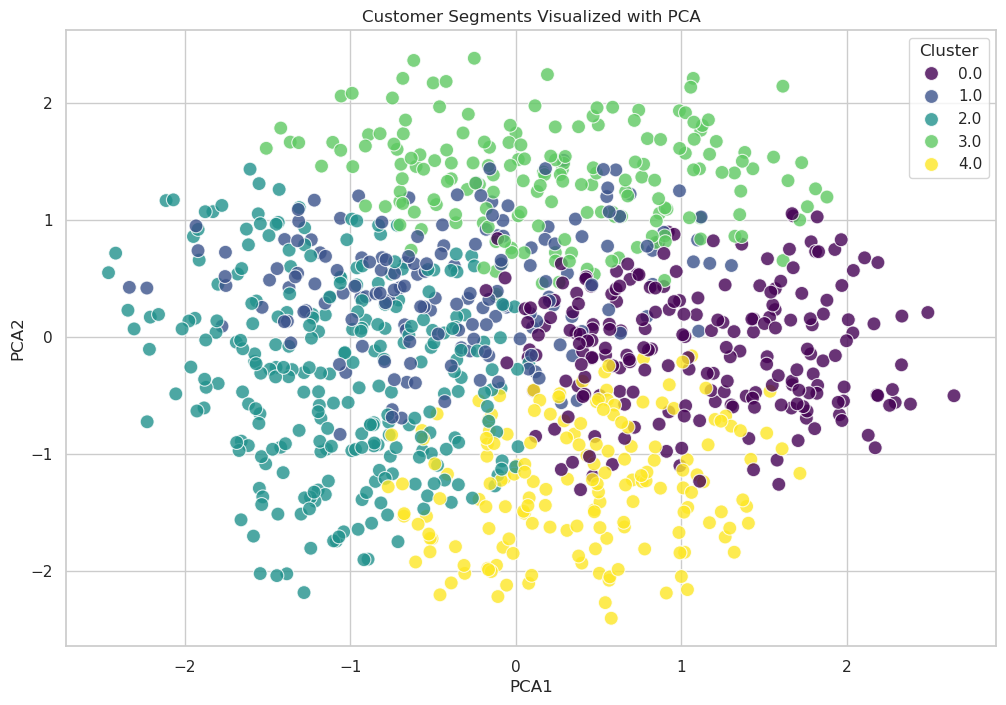

In [21]:
# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=100, alpha=0.8)
plt.title('Customer Segments Visualized with PCA')
plt.legend(title='Cluster')
plt.show()

## Phase 7: Documentation & Cleanup

### Step 12: Documentation and Summary

In [26]:
print("\n" + "="*60)
print("CUSTOMER SEGMENTATION MODEL DEPLOYMENT SUMMARY")
print("="*60)
print(f"✅ Model Training: Completed with k={K} clusters")
print(f"✅ Model Deployment: Deployed to endpoint '{kmeans_predictor.endpoint_name}'")
print(f"✅ Real-time Predictions: Working endpoint available for inference")
print(f"✅ Model Artifacts: Stored at {kmeans_sagemaker.model_data}")
print("="*60)


CUSTOMER SEGMENTATION MODEL DEPLOYMENT SUMMARY
✅ Model Training: Completed with k=5 clusters
✅ Model Deployment: Deployed to endpoint 'kmeans-2025-07-31-02-15-33-551'
✅ Real-time Predictions: Working endpoint available for inference
✅ Model Artifacts: Stored at s3://sagemaker-us-east-1-790768631355/sagemaker/customer-segmentation-kmeans/output/kmeans-2025-07-31-02-10-36-690/output/model.tar.gz


### IMPORTANT: Cleanup (Uncomment when done testing)

In [4]:
# Delete the endpoint to avoid ongoing charges
print("\nTo clean up, uncomment and run the following line:")
kmeans_predictor.delete_endpoint()
print("Endpoint deleted successfully!")


To clean up, uncomment and run the following line:


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # Delete the endpoint to avoid ongoing charges                                               │
│   2 print("\nTo clean up, uncomment and run the following line:")                                │
│ ❱ 3 kmeans_predictor.delete_endpoint()                                                           │
│   4 print("Endpoint deleted successfully!")                                                      │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'kmeans_predictor' is not defined

In [27]:
print(f"\n🎯 DELIVERABLE: Working SageMaker Endpoint URL for predictions")
print(f"Endpoint Name: {kmeans_predictor.endpoint_name}")
print(f"Region: {sagemaker_session.boto_region_name}")
print(f"Usage: Call the predict() method of the predictor object with your scaled feature data.")


🎯 DELIVERABLE: Working SageMaker Endpoint URL for predictions
Endpoint Name: kmeans-2025-07-31-02-15-33-551
Region: us-east-1
Usage: Call the predict() method of the predictor object with your scaled feature data.
